In [1]:
import pandas as pd
import numpy as np 
import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 
from sklearn import metrics
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore

import warnings 
warnings.filterwarnings('ignore')

# Linear Regression

### Problem 1: Linear Regression

You are hired by a company Gem Stones co ltd, which is a cubic zirconia manufacturer. You are provided with the dataset containing the prices and other attributes of almost 27,000 cubic zirconia (which is an inexpensive diamond alternative with many of the same qualities as a diamond). The company is earning different profits on different prize slots. You have to help the company in predicting the price for the stone on the bases of the details given in the dataset so it can distinguish between higher profitable stones and lower profitable stones so as to have better profit share. Also, provide them with the best 5 attributes that are most important.


In [2]:
gem = pd.read_csv('cubic_zirconia.csv')
gem.drop(columns='Unnamed: 0',inplace=True)
gem.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [3]:
gem.tail()

,carat,cut,color,clarity,depth,table,x,y,z,price
26962,1.11,Premium,G,SI1,62.3,58.0,6.61,6.52,4.09,5408
26963,0.33,Ideal,H,IF,61.9,55.0,4.44,4.42,2.74,1114
26964,0.51,Premium,E,VS2,61.7,58.0,5.12,5.15,3.17,1656
26965,0.27,Very Good,F,VVS2,61.8,56.0,4.19,4.20,2.60,682
26966,1.25,Premium,J,SI1,62.0,58.0,6.90,6.88,4.27,5166


In [4]:
gem.describe()

,carat,depth,table,x,y,z,price
count,26967.000000,26270.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000
mean,0.798375,61.745147,57.456080,5.729854,5.733569,3.538057,3939.518115
std,0.477745,1.412860,2.232068,1.128516,1.166058,0.720624,4024.864666
min,0.200000,50.800000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.710000,2.900000,945.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2375.000000
75%,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,5360.000000
max,4.500000,73.600000,79.000000,10.230000,58.900000,31.800000,18818.000000


In [5]:
gem.shape

(26967, 10)

In [6]:
print('Total number of null values before imputing is',gem.isnull().sum().sum())

Total number of null values before imputing is 697


### Univariate Analysis

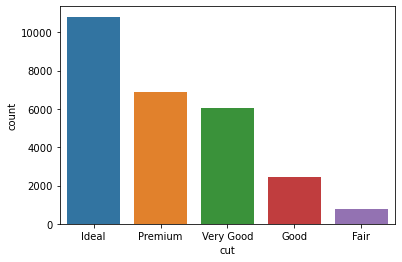

In [7]:
# bar plot
sns.countplot(gem.cut);

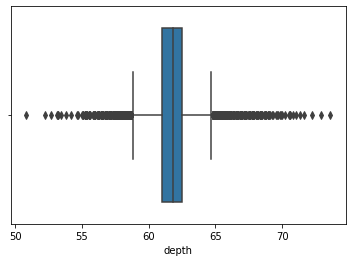

In [8]:
# boxplot
sns.boxplot(gem.depth);

### Bivariate Analysis

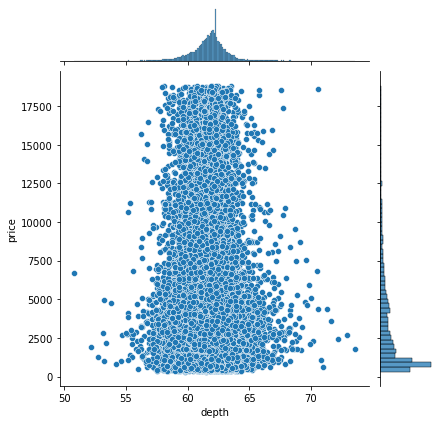

In [9]:
# joint plot
sns.jointplot(gem['depth'],gem['price']);

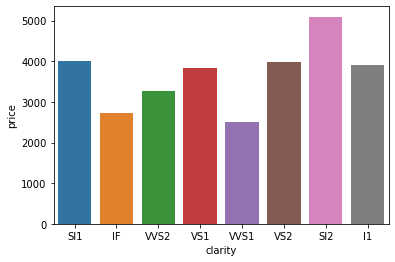

In [10]:
# stripplot
sns.barplot(x=gem.clarity , y=gem.price,ci=None);

### Multivariate Analysis

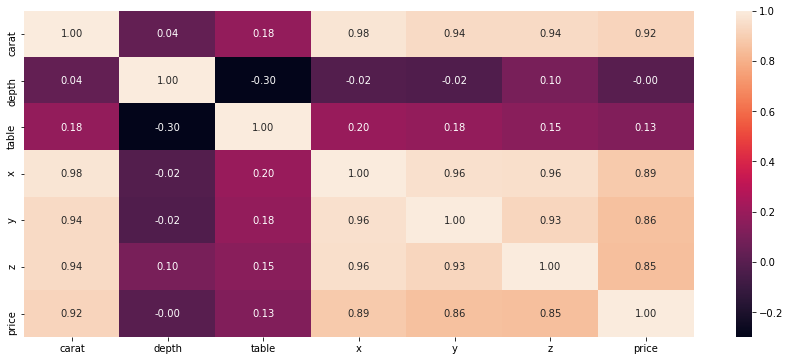

In [11]:
corr = gem.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot=True, fmt = '.2f');

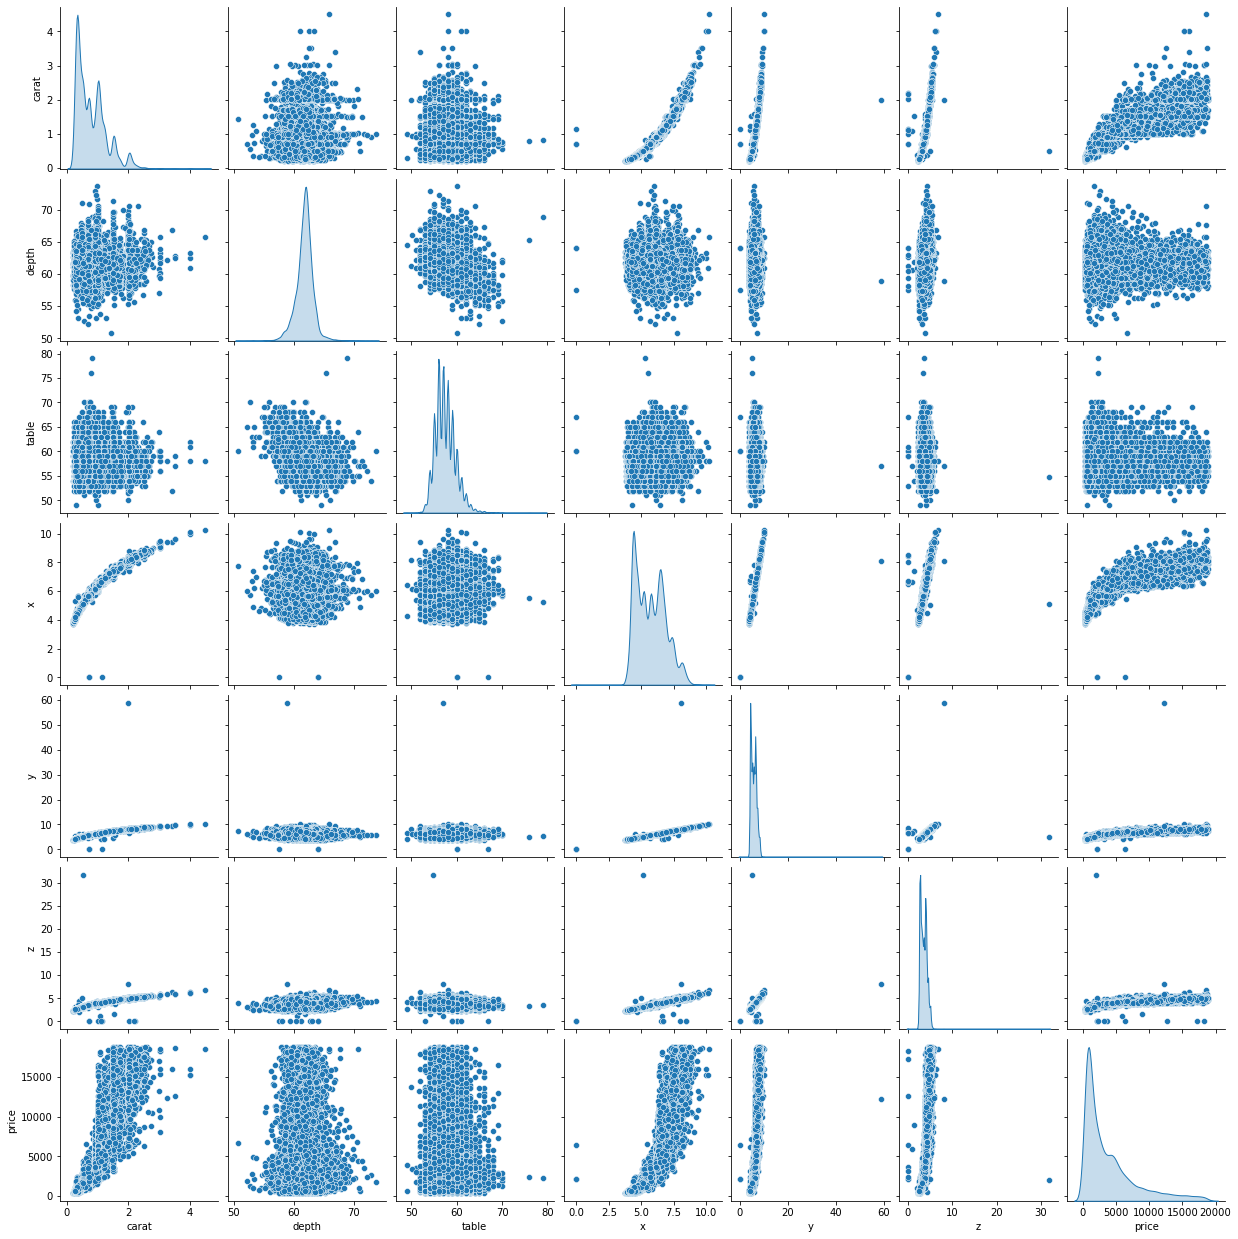

In [12]:
sns.pairplot(gem,diag_kind='kde');

#### Its not good to remove the records having missing values all the time. We may end up loosing some data points. So, we will have to see how to replace those missing values with some estimated values (median)

In [13]:
imputer = SimpleImputer(missing_values=np.nan,strategy='median')
imputer.fit(gem.iloc[:,4:5])
imputed_data = imputer.transform(gem.iloc[:,4:5].values)
gem.iloc[:,4:5] = imputed_data

#####  Removing outliers from the depth

In [14]:
print('Total number of null values after imputing is',gem.isnull().sum().sum())

Total number of null values after imputing is 0


In [15]:
gem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    26967 non-null  float64
 1   cut      26967 non-null  object 
 2   color    26967 non-null  object 
 3   clarity  26967 non-null  object 
 4   depth    26967 non-null  float64
 5   table    26967 non-null  float64
 6   x        26967 non-null  float64
 7   y        26967 non-null  float64
 8   z        26967 non-null  float64
 9   price    26967 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 2.1+ MB


In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
gemd = gem.select_dtypes(exclude=['object'])

# update the cols with their normalized values
gem[gemd.columns] = sc.fit_transform(gemd)

In [17]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [18]:
lr,ur=remove_outlier(gem.depth)
gem.depth=np.where(gem.depth>ur,ur,gem.depth)
gem.depth=np.where(gem.depth<lr,lr,gem.depth)

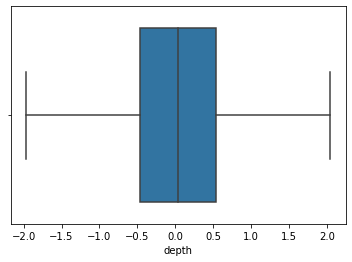

In [19]:
sns.boxplot(gem.depth);

#### To convert categorical data from objects into integers using label encoding

In [20]:
gemonehot = pd.get_dummies(gem,columns=['cut','color','clarity'],drop_first=True)
# drop first is made true to reduce dummy trap problem

In [21]:
gemonehot.head()

,carat,depth,table,x,y,z,price,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.043201,0.253453,0.243689,-1.293628,-1.238014,-1.218491,-0.854832,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,-0.980405,-0.678792,0.243689,-1.160708,-1.092221,-1.162983,-0.734329,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0.212721,0.325164,1.139736,0.274832,0.331406,0.335747,0.583753,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.792017,-0.105103,-0.652358,-0.806254,-0.800635,-0.802177,-0.709979,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,-1.022269,-0.965637,0.691712,-1.222737,-1.117949,-1.232368,-0.785263,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
# 

In [23]:
X = gemonehot.drop('price',axis=1)
Y = gemonehot.price
x_train1 , x_test1 , y_train1 , y_test1 = train_test_split(X,Y,test_size=0.3,random_state=1)

In [24]:
linear_model = LinearRegression()
linear_model.fit(x_train1,y_train1)

LinearRegression()

In [25]:
intercept = linear_model.intercept_
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -1.0476440983159856


In [26]:
for idx, col_name in enumerate(x_train1.columns):
    print("The coefficient for {} is {}".format(col_name,linear_model.coef_[idx]))

The coefficient for carat is 1.3318892647093354
The coefficient for depth is -0.023662334068712997
The coefficient for table is -0.015054537193578875
The coefficient for x is -0.27503858859539776
The coefficient for y is -0.0013422741196084775
The coefficient for z is -0.009026606739446537
The coefficient for cut_Good is 0.13089872669610342
The coefficient for cut_Ideal is 0.19875969281511321
The coefficient for cut_Premium is 0.1720664221401289
The coefficient for cut_Very Good is 0.16522492442311376
The coefficient for color_E is -0.04967608391111707
The coefficient for color_F is -0.07133803044245939
The coefficient for color_G is -0.11726718578313688
The coefficient for color_H is -0.24059275084306256
The coefficient for color_I is -0.3731419095684082
The coefficient for color_J is -0.5925525929298248
The coefficient for clarity_IF is 1.343275822959704
The coefficient for clarity_SI1 is 0.946121345910691
The coefficient for clarity_SI2 is 0.7094812896129413
The coefficient for clar

In [27]:
print( 'The score of the model for the testing set is', linear_model.score(x_test1,y_test1) )

The score of the model for the testing set is 0.922955289149439


In [28]:
print( 'The score of the model for the training set is',linear_model.score(x_train1,y_train1))

The score of the model for the training set is 0.9202211425206703


In [29]:
y_pred1 = linear_model.predict(x_test1)

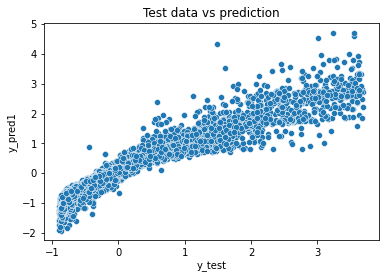

In [30]:
sns.scatterplot(y_test1,y_pred1);
plt.xlabel('y_test');
plt.ylabel('y_pred1');
plt.title('Test data vs prediction');

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, ix) for ix in range(X.shape[1])]

In [32]:
i=0
for column in X.columns:
    if i < 27:
        print (column ,"--->",  vif[i])
        i = i+1

carat ---> 23.609689686089972
depth ---> 1.5528616344755648
table ---> 1.742089008617014
x ---> 45.37075412284442
y ---> 13.95113993620259
z ---> 14.032118182295342
cut_Good ---> 3.496437266066383
cut_Ideal ---> 14.421302501125455
cut_Premium ---> 8.65306433277053
cut_Very Good ---> 7.639882842322413
color_E ---> 2.366943708157424
color_F ---> 2.325147465557399
color_G ---> 2.6637696754813316
color_H ---> 2.1984851525474296
color_I ---> 1.8712033946889979
color_J ---> 1.487179428763507
clarity_IF ---> 2.1948239325098506
clarity_SI1 ---> 8.832052203355904
clarity_SI2 ---> 6.265109423058851
clarity_VS1 ---> 6.041387644134596
clarity_VS2 ---> 8.417973451681862
clarity_VVS1 ---> 3.4213578260726014
clarity_VVS2 ---> 4.18218568061231


#### 5 best attributes that are important are 
- carat 
- clarity_IF
- clarity_VVS1
- clarity_VVS2
- clarity_VS1
- clarity_VS2

#### The ideal , premium and very good cut types are the one which are bringing profits so that we could use marketing to boost the profits 

# Logistic Regression Model

### Problem 2: Logistic Regression and LDA (20 marks)

You are hired by a tour and travel agency which deals in selling holiday packages. You are provided details of 872 employees of a company. Among these employees, some opted for the package and some didn't. You have to help the company in predicting whether an employee will opt for the package or not on the basis of the information given in the data set. Also, find out the important factors on the basis of which the company will focus on particular employees to sell their packages.

In [33]:
holipack = pd.read_csv('Holiday_Package.csv')
holipack.drop('Unnamed: 0',axis=1,inplace=True)
holipack.head()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,no,48412,30,8,1,1,no
1,yes,37207,45,8,0,1,no
2,no,58022,46,9,0,0,no
3,no,66503,31,11,2,0,no
4,no,66734,44,12,0,2,no


In [34]:
holipack.tail()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
867,no,40030,24,4,2,1,yes
868,yes,32137,48,8,0,0,yes
869,no,25178,24,6,2,0,yes
870,yes,55958,41,10,0,1,yes
871,no,74659,51,10,0,0,yes


In [35]:
holipack.shape

(872, 7)

In [36]:
holipack.groupby('Holliday_Package').count()

,Salary,age,educ,no_young_children,no_older_children,foreign
Holliday_Package,,,,,,
no,471,471,471,471,471,471
yes,401,401,401,401,401,401


In [37]:
holipack.groupby('foreign').count()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children
foreign,,,,,,
no,656,656,656,656,656,656
yes,216,216,216,216,216,216


In [38]:
holipack.describe().T

,count,mean,std,min,25%,50%,75%,max
Salary,872.0,47729.172018,23418.668531,1322.0,35324.0,41903.5,53469.5,236961.0
age,872.0,39.955275,10.551675,20.0,32.0,39.0,48.0,62.0
educ,872.0,9.307339,3.036259,1.0,8.0,9.0,12.0,21.0
no_young_children,872.0,0.311927,0.612870,0.0,0.0,0.0,0.0,3.0
no_older_children,872.0,0.982798,1.086786,0.0,0.0,1.0,2.0,6.0


### Univariate Analysis

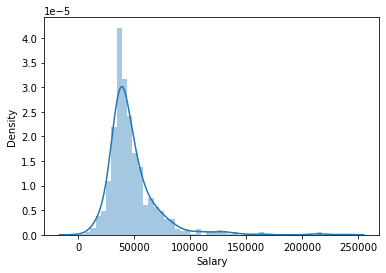

In [39]:
#boxplot, dist, crosstab.plot()
sns.distplot(holipack.Salary);

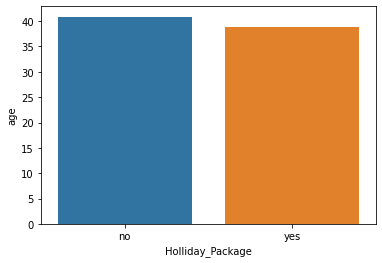

In [40]:
sns.barplot(x=holipack.Holliday_Package, y=holipack.age ,ci=None);

### Bivariate Analysis

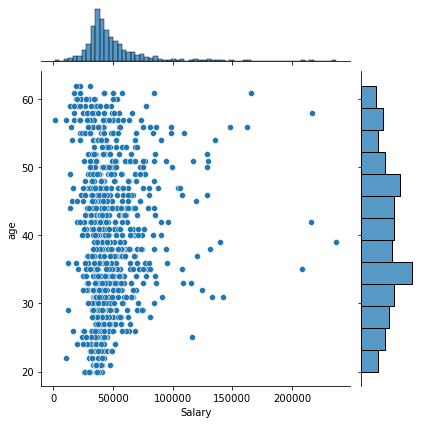

In [41]:
# jointplot , histogram
sns.jointplot(data=holipack,x='Salary',y='age')

### Multivariate Analysis

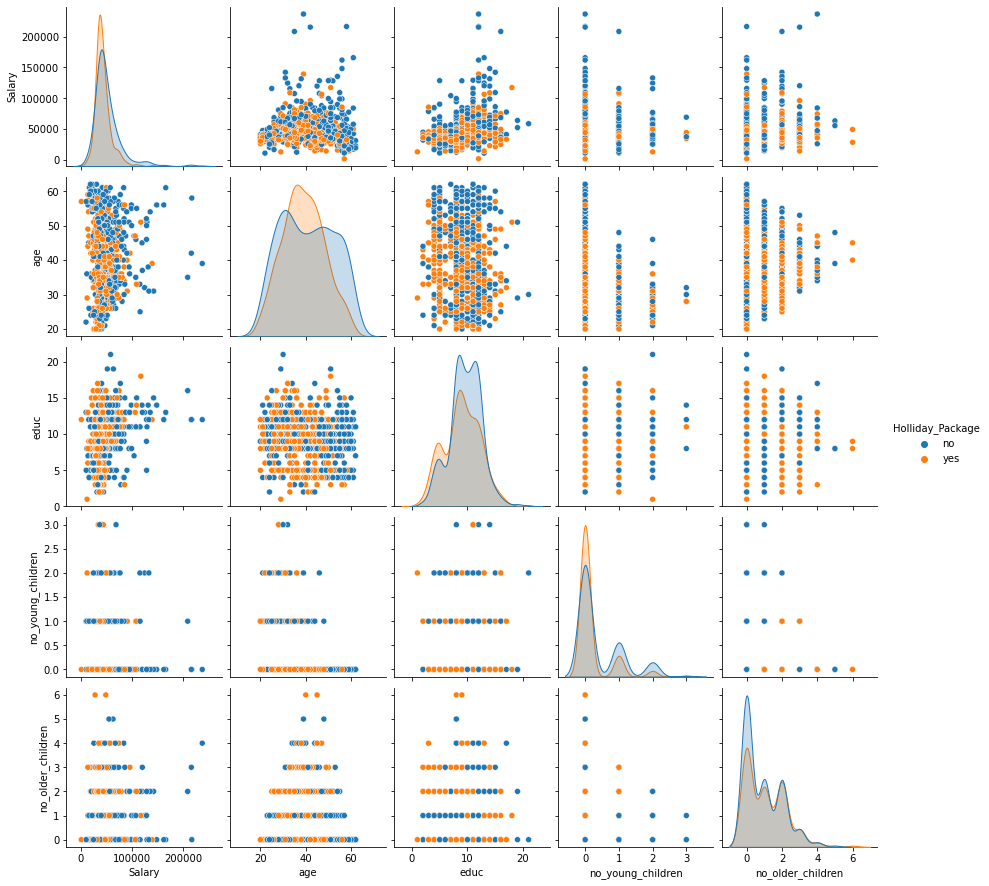

In [42]:
sns.pairplot(holipack,diag_kind='kde',hue='Holliday_Package');

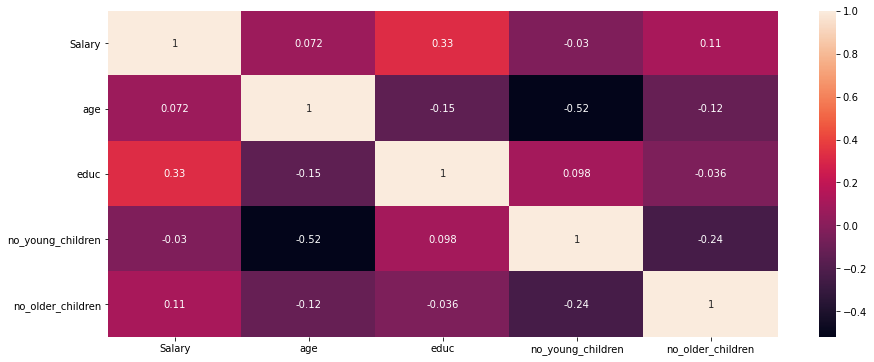

In [43]:
corr = holipack.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr,annot=True);

In [44]:
holipack.head()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,no,48412,30,8,1,1,no
1,yes,37207,45,8,0,1,no
2,no,58022,46,9,0,0,no
3,no,66503,31,11,2,0,no
4,no,66734,44,12,0,2,no


In [45]:
holipackonehot = pd.get_dummies(holipack, columns=['Holliday_Package','foreign'],drop_first=True)
holipackonehot.head()
# the first dummy is dropped to handle dummy variables trap

,Salary,age,educ,no_young_children,no_older_children,Holliday_Package_yes,foreign_yes
0,48412,30,8,1,1,0,0
1,37207,45,8,0,1,1,0
2,58022,46,9,0,0,0,0
3,66503,31,11,2,0,0,0
4,66734,44,12,0,2,0,0


In [46]:
#holipackonehot.groupby('Holliday_Package_yes').count()

So we have 54.01% people who didn't choose the holiday package in the dataset , it is a good distribution of the people among who chose and didn't choose.

In [47]:

X = holipackonehot.drop({'Holliday_Package_yes'},axis=1)
Y = holipackonehot.Holliday_Package_yes
Xscaled = X.apply(zscore)

In [48]:

x_train2 , x_test2 , y_train2 , y_test2 = train_test_split(Xscaled,Y, test_size=0.3,random_state=1)

In [49]:
print('The shape of X train split data',x_train2.shape)
print('The shape of Y train split data',y_train2.shape)

The shape of X train split data (610, 6)
The shape of Y train split data (610,)


In [50]:
print('The shape of X test split data',x_test2.shape)
print('The shape of Y test split data',y_test2.shape)

The shape of X test split data (262, 6)
The shape of Y test split data (262,)


In [51]:
logistic_model = LogisticRegression(max_iter=100)
logistic_model.fit(x_train2,y_train2)

LogisticRegression()

In [52]:
for idx, col_name in enumerate(x_train2.columns):
    print("The coefficient for {} is {}".format(col_name,logistic_model.coef_[0][idx]))

The coefficient for Salary is -0.4018215927578848
The coefficient for age is -0.5626369116901058
The coefficient for educ is 0.22962820068946965
The coefficient for no_young_children is -0.9230301031161489
The coefficient for no_older_children is -0.0557768401319321
The coefficient for foreign_yes is 0.673796137429403


In [53]:
print('The score of the logistic model on training data is',logistic_model.score(x_train2,y_train2))

The score of the logistic model on training data is 0.680327868852459


In [54]:
print('The score of the logistic model on testing data is',logistic_model.score(x_test2,y_test2))

The score of the logistic model on testing data is 0.6374045801526718


In [55]:
y_pred = logistic_model.predict(x_test2)

In [56]:
print('The accuracy of the predicted model', metrics.accuracy_score(y_test2,y_pred))

The accuracy of the predicted model 0.6374045801526718


              precision    recall  f1-score   support

           0       0.66      0.70      0.68       145
           1       0.60      0.56      0.58       117

    accuracy                           0.64       262
   macro avg       0.63      0.63      0.63       262
weighted avg       0.64      0.64      0.64       262



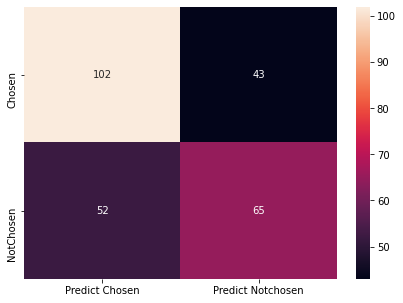

In [57]:
cm=metrics.confusion_matrix(y_test2, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ["Chosen","NotChosen"]],
                  columns = [i for i in ["Predict Chosen","Predict Notchosen"]])
plt.figure(figsize = (7,5))
print(metrics.classification_report(y_test2,y_pred))
sns.heatmap(df_cm, annot=True,fmt='g');

## LDA 

In [58]:
holipack.head()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,no,48412,30,8,1,1,no
1,yes,37207,45,8,0,1,no
2,no,58022,46,9,0,0,no
3,no,66503,31,11,2,0,no
4,no,66734,44,12,0,2,no


In [59]:
holipack.tail()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
867,no,40030,24,4,2,1,yes
868,yes,32137,48,8,0,0,yes
869,no,25178,24,6,2,0,yes
870,yes,55958,41,10,0,1,yes
871,no,74659,51,10,0,0,yes


In [60]:
holipacklda = holipack.copy()

In [61]:
holipacklda.foreign = np.where(holipacklda.foreign =='yes','1',holipacklda.foreign)
holipacklda.foreign = np.where(holipacklda.foreign =='no','0',holipacklda.foreign)
holipacklda.head()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,no,48412,30,8,1,1,0
1,yes,37207,45,8,0,1,0
2,no,58022,46,9,0,0,0
3,no,66503,31,11,2,0,0
4,no,66734,44,12,0,2,0


In [62]:
from sklearn.preprocessing import scale
X = holipacklda.drop('Holliday_Package',axis=1)
X = scale(X)
Y = holipacklda.Holliday_Package
x_train , x_test , y_train , y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()

model = clf.fit(X,Y)

In [64]:
y_pred= clf.predict(x_test)

In [65]:
print('The shape of X train split data',x_train.shape)
print('The shape of Y train split data',y_train.shape)
print('The shape of X test split data',x_test.shape)
print('The shape of Y test split data',y_test.shape)

The shape of X train split data (697, 6)
The shape of Y train split data (697,)
The shape of X test split data (175, 6)
The shape of Y test split data (175,)


In [66]:
print('The score of the LDA model on training data is',clf.score(x_train,y_train))

The score of the LDA model on training data is 0.6628407460545194


In [67]:
print('The score of the LDA model on testing data is',clf.score(x_test,y_test))

The score of the LDA model on testing data is 0.6628571428571428


In [68]:
print('The accuracy of the predicted model',metrics.accuracy_score(y_test,y_pred))

The accuracy of the predicted model 0.6628571428571428


              precision    recall  f1-score   support

          no       0.67      0.73      0.70        94
         yes       0.65      0.58      0.61        81

    accuracy                           0.66       175
   macro avg       0.66      0.66      0.66       175
weighted avg       0.66      0.66      0.66       175



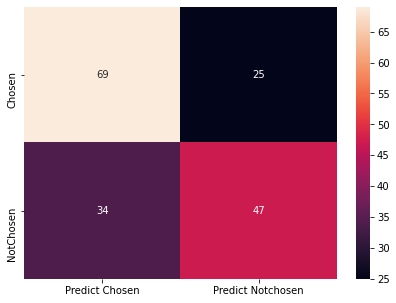

In [69]:
cm=metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ["Chosen","NotChosen"]],
                  columns = [i for i in ["Predict Chosen","Predict Notchosen"]])
plt.figure(figsize = (7,5))
print(metrics.classification_report(y_test,y_pred))
sns.heatmap(df_cm, annot=True,fmt='g');

#### From the above , LDA has better precision , accuracy and f1-score and is cleary a better model for this than logistic regression

# END